# Analysis of SEIRX model runs for test technology and vaccination ratios

In [12]:
import pandas as pd
import numpy as np
from os.path import join
import analysis_functions as af

In [2]:
language = 'english'
# vaccination ratios of (employee, resident) groups corresponding to the
# different vaccination scenarios
vaccination_scenarios = [(0, 0), (0.5, 0.0), (0.0, 0.5), (0.5, 0.9), (0.9, 0.9)]

## Mappings of variables to plot labels

Since these plots were also used to advise Austrian decision makers, we provide plot label mappings to German for easier communication of results.

In [3]:
# English
if language == 'english':
    frequency_name_map = {np.nan:'never',
              2:'3 times\na week',
              3:'twice\na week',
              7:'once\na week'}

    test_name_map = {
        'same_day_antigen':'same-day antigen',
        'one_day_PCR':'one day PCR',
        'two_day_PCR':'two days PCR',
        'same_day_PCR':'same-day PCR',
        'same_day_LAMP':'same-day RT-LAMP',
        None:''}

    metric_name_map = {
        'infected_residents_mean':'follow-up cases residents (mean)',
        'infected_residents_median':'follow-up cases residends (median)',
        'infected_residents_0.90':'follow-up cases residents (90th percentile)',
        'R0_mean':'$R_0$',
        'R0_mean':'$R_0$',
        'infected_residents':'follow-up cases residents'}

    index_case_map = {'employee':'index case employee',
                      'resident':'index case resident'}
    
    xlabel = 'screening frequency employees'
    ylabel = 'screening freuqency residents'
    
    screening_intervals = ['never', 'once\na week', 'twice\na week', 
                           '3 times\na week']
    
    vacc_scenario_labels = ['no\nvaccination', 'emp. 50%\nres. 0%', 
                            'emp. 0%\nres. 50%',  'emp. 50%\nres. 90%',
                             'emp. 90%\nres. 90%']
    
    test_strat_labels = ['testing employees 2x/week',
                         'testing everyone 1x/week',
                         'no testing']
    
    index_case_label = 'index case'
    employee_label = 'employee'
    resident_label = 'resident'

# German
if language == 'german':
    frequency_name_map = {np.nan:'nie',
                  2:'3 mal\npro Woche',
                  3:'2 mal\npro Woche',
                  7:'ein mal\npro Woche'}

    test_name_map = {
        'same_day_antigen':'Antigen (selber Tag)',
        'one_day_PCR':'PCR (1 Tag)',
        'two_day_PCR':'PCR (2 Tage)',
        'same_day_PCR':'PCR (selber Tag)', 
        'same_day_LAMP':'RT-LAMP (selber Tag)',
        None:''}

    metric_name_map = {
        'infected_residents_mean':'Folgefälle BewohnerInnen (Mittelwert)',
        'infected_residents_median':'Folgefälle BewohnerInnen (Median)',
        'infected_residents_0.90':'Folgefälle BewohnerInnen (90. Percentile)',
        'R0_mean':'$R_0$',
        'R0_mean':'$R_0$',
        'infected_residents':'Folgefälle BewohnerInnen'}

    index_case_map = {'employee':'keine Besuche',
                      'resident':'Besuche'}
    
    xlabel = 'Testfrequenz MitarbeiterInnen'
    ylabel = 'Testfrequenz BewohnerInnen'
    
    screening_intervals = ['nie', 'ein mal\npro Woche', '2 mal\npro Woche',
                           '3 mal\npro Woche']

    vacc_scenario_labels = ['keine\nImpfungen', 'Mit. 50%\nBew. 0%', 
                            'Mit. 0%\nBew. 50%',  'Mit. 50%\nBew. 90%',
                             'Mit. 90%\Bew. 90%']
    
    test_strat_labels = ['Testen MitarbeiterInnen 2x/Woche',
                         'Testen alle 1x/Woche',
                         'keine Tests']
    
    index_case_label = 'Indexfall'
    employee_label = 'MitarbeiterIn'
    resident_label = 'BewohnerIn'

## Analysis B.1.1.7

### Violin plots

#### Load simulation results

In [4]:
test_types = ['same_day_antigen', 'same_day_PCR', None]
index_cases = ['employee', 'resident']
vaccination_scenarios_and_labels = [
                         (0.5, 0.0, vacc_scenario_labels[1]),
                         (0.0, 0.5, vacc_scenario_labels[2]),
                         (0.5, 0.9, vacc_scenario_labels[3]),
                         #(0.9, 0.9, vacc_scenario_labels[3])
                        ]

testing_strats = [(3, None, test_strat_labels[0]),
                     (7, 7, test_strat_labels[1])]

testing_scenarios = np.asarray([
        test_strat_labels[0] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[0] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[2] + '\n' + test_name_map[test_types[2]]])

In [5]:
# load the vaccination scenario X testing strategy data
params = [(t, i, j, k, l, m, n, o) \
             for t in test_types[0:2]
             for i in index_cases\
             for j, k, l in testing_strats\
             for m, n, o in vaccination_scenarios_and_labels]

ensmbls = pd.DataFrame()
for p in params:
    ensmbls = pd.concat([ensmbls, af.load_ensmbl(p, test_name_map, 
                                                 variant='UK_variant')])

In [6]:
# load the baseline data (only testing strategies)
params = [(t, i, j, k, l, vacc_scenario_labels[0]) \
          for t in test_types[0:2]\
          for i in index_cases\
          for j, k, l in testing_strats]

baseline_ensmbls = pd.DataFrame()
for p in params:
    baseline_ensmbls = pd.concat([baseline_ensmbls, 
                af.load_baseline_ensmbl(p, test_name_map, variant='UK_variant')])

In [8]:
# load the data without testing
params = [(None, i, None, None, test_strat_labels[2], j, k, l) \
          for i in index_cases \
          for j, k, l in vaccination_scenarios_and_labels]

no_test_ensmbls = pd.DataFrame()
for p in params:
    no_test_ensmbls = pd.concat([no_test_ensmbls, 
            af.load_no_test_ensmbl(p, test_name_map, variant='UK_variant')])

In [9]:
# load the data without testing and vaccinations
params = [(None, i, None, None, test_strat_labels[2], 0, 0, vacc_scenario_labels[0]) \
          for i in index_cases]

TTI_ensmbl = pd.DataFrame()
for p in params:
    TTI_ensmbl = pd.concat([TTI_ensmbl, af.load_TTI_ensmbl(p, variant='UK_variant')])


In [10]:
ensmbls = pd.concat([ensmbls, baseline_ensmbls,
                     no_test_ensmbls, TTI_ensmbl])

#### Plots

**Testing scenarios**
* Employees screened 2x / week with antigen tests, residents never
* Employees screened 2x / week with PCR tests, residents never
* No testing

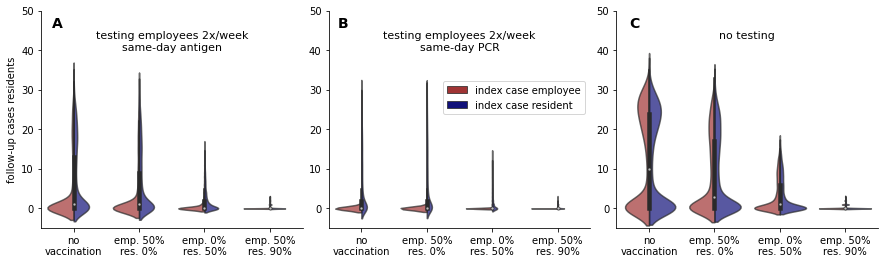

In [21]:
af.plot_violins2(ensmbls, 'infected_residents', testing_scenarios[[0, 1, 4]],
            vacc_scenario_labels[0:4], metric_name_map, index_case_map,
            language, ymin=-5, ymax=50, variant='_UK_variant')

**Testing**
* Employees screened 2x / week with antigen tests, residents never
* Employees screened 2x / week with PCR tests, residents never
* Employees screened 1x / week, residents screened 1x / week, both with antigen tests
* Employees screened 1x / week, residents screened 1x / week, both with PCR tests

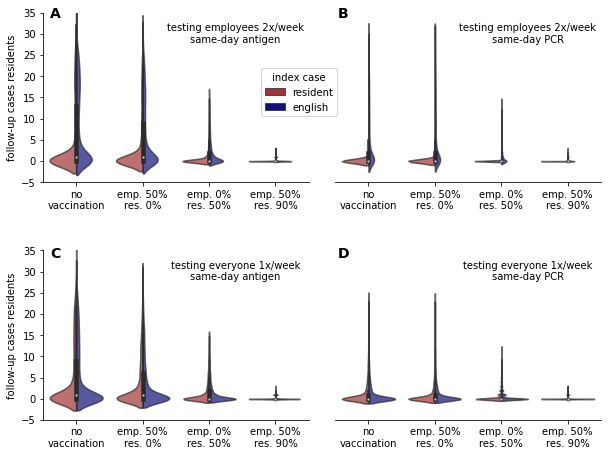

In [30]:
af.plot_violins(ensmbls, 'infected_residents', testing_scenarios[0:4],
             vacc_scenario_labels[0:4], metric_name_map, index_case_map,
             index_case_label, employee_label, resident_label, language, ymin=-5,
             ymax=35, variant='_UK_variant')

### Colormaps for different vaccination scenarios

#### Load the simulation results

In [31]:
N_runs = 5000
sim_name = 'simulations_testing_and_vaccination_UK_variant_{}.csv'.format(N_runs)
res_path = '../data/simulation_results'
dst_path = '../plots'

In [32]:
data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

data = data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [33]:
N_runs = 5000
sim_name = 'simulations_testing_strategy_UK_variant_{}.csv'.format(N_runs)

In [34]:
no_vacc_data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
no_vacc_data['resident_screen_interval'] = no_vacc_data['resident_screen_interval']\
    .replace(frequency_name_map)
no_vacc_data['employee_screen_interval'] = no_vacc_data['employee_screen_interval']\
    .replace(frequency_name_map)
no_vacc_data['employee_vaccination_ratio'] = 0.0
no_vacc_data['resident_vaccination_ratio'] = 0.0

no_vacc_data = no_vacc_data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [35]:
data = pd.concat([data, no_vacc_data])

In [36]:
N_runs = 5000
sim_name = 'simulations_vaccination_rate_UK_variant_{}.csv'.format(N_runs)

In [37]:
no_test_data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
no_test_data['resident_screen_interval'] = no_test_data['resident_screen_interval']\
    .replace(frequency_name_map)
no_test_data['employee_screen_interval'] = no_test_data['employee_screen_interval']\
    .replace(frequency_name_map)

no_test_data = no_test_data.set_index(['index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

#### Plots

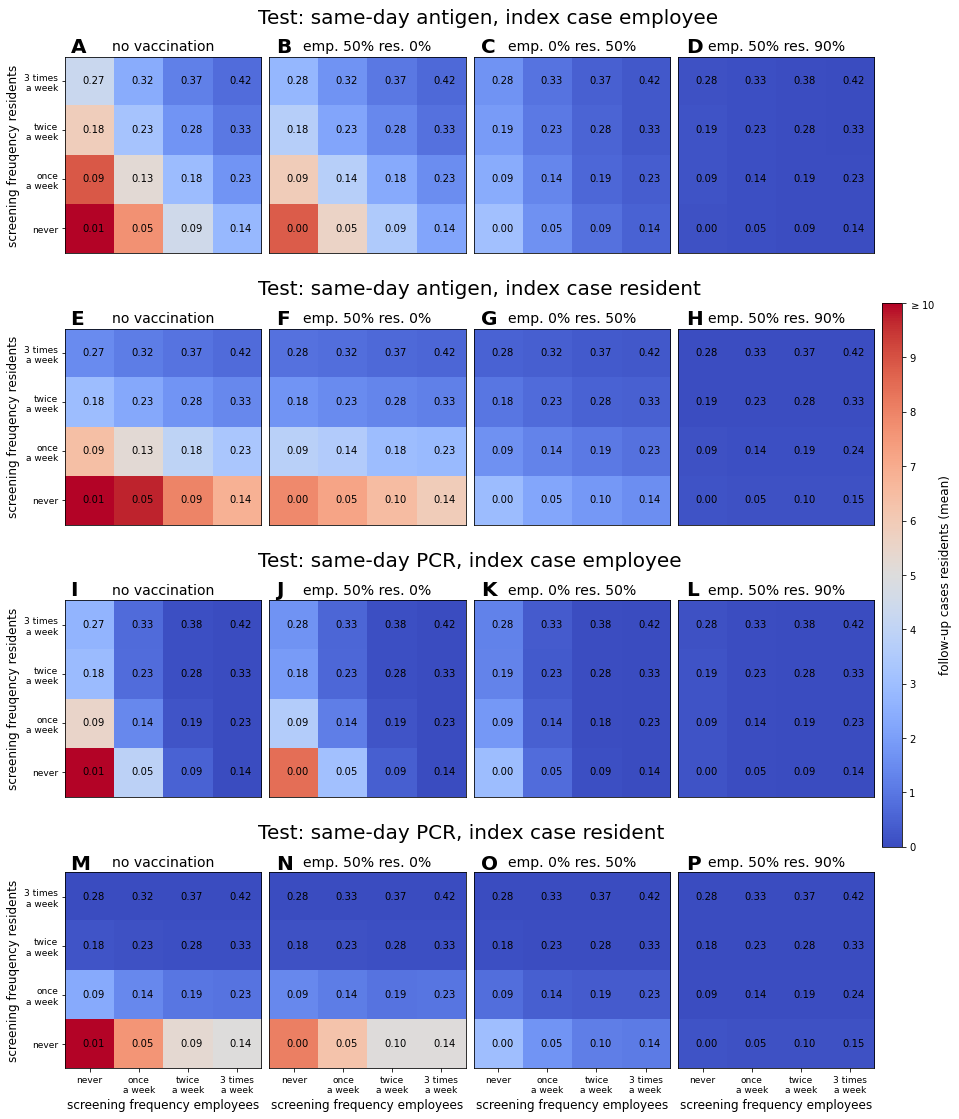

In [55]:
af.plot_testing_strategy_vaccination_scenario_grid(\
    data, 'infected_residents_mean', screening_intervals,
    vaccination_scenarios[0:4], test_name_map, index_case_map,
    vacc_scenario_labels, metric_name_map, xlabel, ylabel, language,
    variant='_UK_variant', vmax=10, vstep=1)

### Outbreak sizes

#### Antigen tests & 50% vaccinated residents

In [56]:
mean = data.loc['same_day_antigen', 'employee', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_antigen', 'employee', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.8798 +- 2.101008045429953


In [57]:
mean = data.loc['same_day_antigen', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.8559999999999999 +- 2.805287494640348


#### PCR tests & 0% vaccinated residents, 0% vaccinated employees

In [58]:
mean = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.5202 +- 2.7129069156140537


In [59]:
mean = data.loc['same_day_PCR', 'resident', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.2848 +- 6.868094575981094


#### PCR tests & 0% vaccinated residents, 50% vaccinated employees

In [60]:
mean = data.loc['same_day_PCR', 'employee', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.4412 +- 2.416218156962737


In [61]:
mean = data.loc['same_day_PCR', 'resident', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.0684 +- 6.7097783618487


#### PCR tests & 50% vaccinated residents

In [62]:
mean = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.5202 +- 2.7129069156140537


In [63]:
mean = data.loc['same_day_PCR', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.1838000000000002 +- 1.9861537003223744


#### PCR tests & 90% vaccinated residents, 50% vaccinated employees

In [64]:
mean = data.loc['same_day_PCR', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0076 +- 0.0956246245156693


In [65]:
mean = data.loc['same_day_PCR', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.13139999999999996 +- 0.3727758473486088


#### Antigen tests & 90% vaccinated residents, 50% vaccinated employees

In [66]:
mean = data.loc['same_day_antigen', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_antigen', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0518 +- 0.2504581918428148


In [67]:
mean = data.loc['same_day_antigen', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.13339999999999996 +- 0.3965298061652308


#### No tests & 90% vaccinated residents, 50% vaccinated employees

In [68]:
mean = no_test_data.loc['employee', 0.5, 0.9, 'never', 'never']['infected_residents_mean']
std = no_test_data.loc['employee', 0.5, 0.9, 'never', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.168 +- 0.4580589084306936


In [69]:
mean = no_test_data.loc['resident', 0.5, 0.9, 'never', 'never']['infected_residents_mean'] - 1
std = no_test_data.loc['resident', 0.5, 0.9, 'never', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.17599999999999993 +- 0.4628896773213614


## Analysis wild type

### Load the simulation results

In [70]:
N_runs = 5000
sim_name = 'simulations_testing_and_vaccination_{}.csv'.format(N_runs)
res_path = '../data/simulation_results'
dst_path = '../plots'

In [71]:
data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

data = data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

### Violin plots

**Realistic scenarios**
* Employees screened 2x / week, residents never, index resident
* Employees screened 2x / week, residents never, index employee
* Employees screened 1x / week, residents screened 1x / week, index resident
* Employees screened 1x / week, residents screened 1x / week, index employee

#### Load simulation results

In [72]:
test_types = ['same_day_antigen', 'same_day_PCR', None]
index_cases = ['employee', 'resident']
vaccination_scenarios_and_labels = [
                         (0.5, 0.0, vacc_scenario_labels[1]),
                         (0.0, 0.5, vacc_scenario_labels[2]),
                         (0.5, 0.9, vacc_scenario_labels[3]),
                         #(0.9, 0.9, vacc_scenario_labels[3])
                        ]

testing_strats = [(3, None, test_strat_labels[0]),
                     (7, 7, test_strat_labels[1])]

testing_scenarios = np.asarray([
        test_strat_labels[0] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[0] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[0]],
        test_strat_labels[1] + '\n' + test_name_map[test_types[1]],
        test_strat_labels[2] + '\n' + test_name_map[test_types[2]]])

In [76]:
# load the vaccination scenario X testing strategy data
params = [(t, i, j, k, l, m, n, o) \
             for t in test_types[0:2]
             for i in index_cases\
             for j, k, l in testing_strats\
             for m, n, o in vaccination_scenarios_and_labels]

ensmbls = pd.DataFrame()
for p in params:
    ensmbls = pd.concat([ensmbls, af.load_ensmbl(p, test_name_map)])

In [78]:
# load the baseline data (only testing strategies)
params = [(t, i, j, k, l, vacc_scenario_labels[0]) \
          for t in test_types[0:2]\
          for i in index_cases\
          for j, k, l in testing_strats]

baseline_ensmbls = pd.DataFrame()
for p in params:
    baseline_ensmbls = pd.concat([baseline_ensmbls, 
                        af.load_baseline_ensmbl(p, test_name_map)])

In [80]:
# load the data without testing
params = [(None, i, None, None, test_strat_labels[2], j, k, l) \
          for i in index_cases \
          for j, k, l in vaccination_scenarios_and_labels]

no_test_ensmbls = pd.DataFrame()
for p in params:
    no_test_ensmbls = pd.concat([no_test_ensmbls, 
                            af.load_no_test_ensmbl(p, test_name_map)])

In [81]:
# load the data without testing and vaccinations
params = [(None, i, None, None, test_strat_labels[2], 0, 0, vacc_scenario_labels[0]) \
          for i in index_cases]

TTI_ensmbl = pd.DataFrame()
for p in params:
    TTI_ensmbl = pd.concat([TTI_ensmbl, af.load_TTI_ensmbl(p)])


In [82]:
ensmbls = pd.concat([ensmbls, baseline_ensmbls,
                     no_test_ensmbls, TTI_ensmbl])

#### Plots

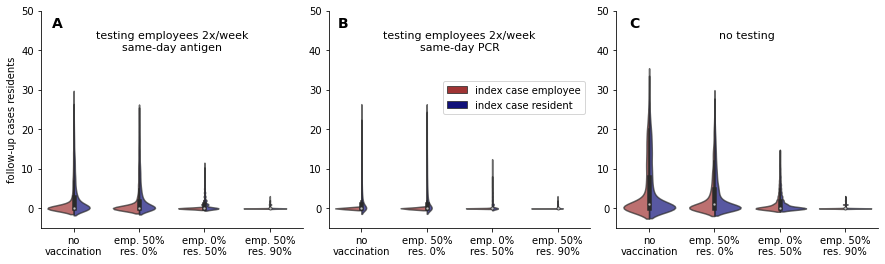

In [83]:
af.plot_violins2(ensmbls, 'infected_residents', testing_scenarios[[0, 1, 4]],
            vacc_scenario_labels[0:4], metric_name_map, index_case_map,
            language, ymin=-5, ymax=50)

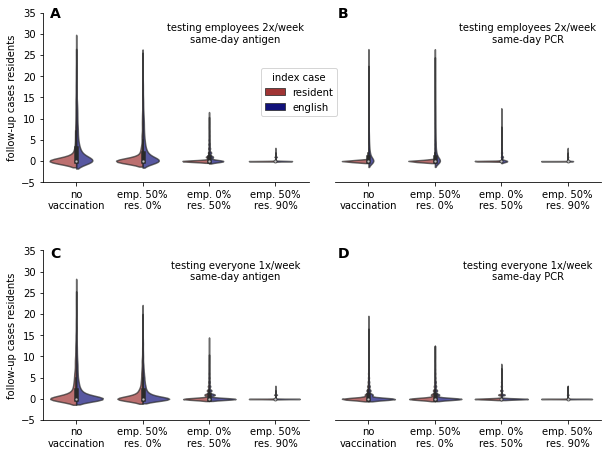

In [84]:
af.plot_violins(ensmbls, 'infected_residents', testing_scenarios[0:4],
             vacc_scenario_labels[0:4], metric_name_map, index_case_map,
             index_case_label, employee_label, resident_label, language,
             ymin=-5, ymax=35)

### Colormaps for different vaccination scenarios

In [85]:
N_runs = 5000
sim_name = 'simulations_testing_and_vaccination_{}.csv'.format(N_runs)
res_path = '../data/simulation_results'
dst_path = '../plots'

In [86]:
data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

data = data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [87]:
N_runs = 5000
sim_name = 'simulations_testing_strategy_{}.csv'.format(N_runs)

In [88]:
no_vacc_data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
no_vacc_data['resident_screen_interval'] = no_vacc_data['resident_screen_interval']\
    .replace(frequency_name_map)
no_vacc_data['employee_screen_interval'] = no_vacc_data['employee_screen_interval']\
    .replace(frequency_name_map)
no_vacc_data['employee_vaccination_ratio'] = 0.0
no_vacc_data['resident_vaccination_ratio'] = 0.0

no_vacc_data = no_vacc_data.set_index(['test_type', 'index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

In [89]:
data = pd.concat([data, no_vacc_data])

In [90]:
N_runs = 5000
sim_name = 'simulations_vaccination_rate_{}.csv'.format(N_runs)

In [91]:
no_test_data = pd.read_csv(join(res_path, sim_name))

# replace strings with strings that are nicer for plotting
no_test_data['resident_screen_interval'] = no_test_data['resident_screen_interval']\
    .replace(frequency_name_map)
no_test_data['employee_screen_interval'] = no_test_data['employee_screen_interval']\
    .replace(frequency_name_map)

no_test_data = no_test_data.set_index(['index_case', 'employee_vaccination_ratio',
                       'resident_vaccination_ratio', 'employee_screen_interval', 
                       'resident_screen_interval'])

#### Plots

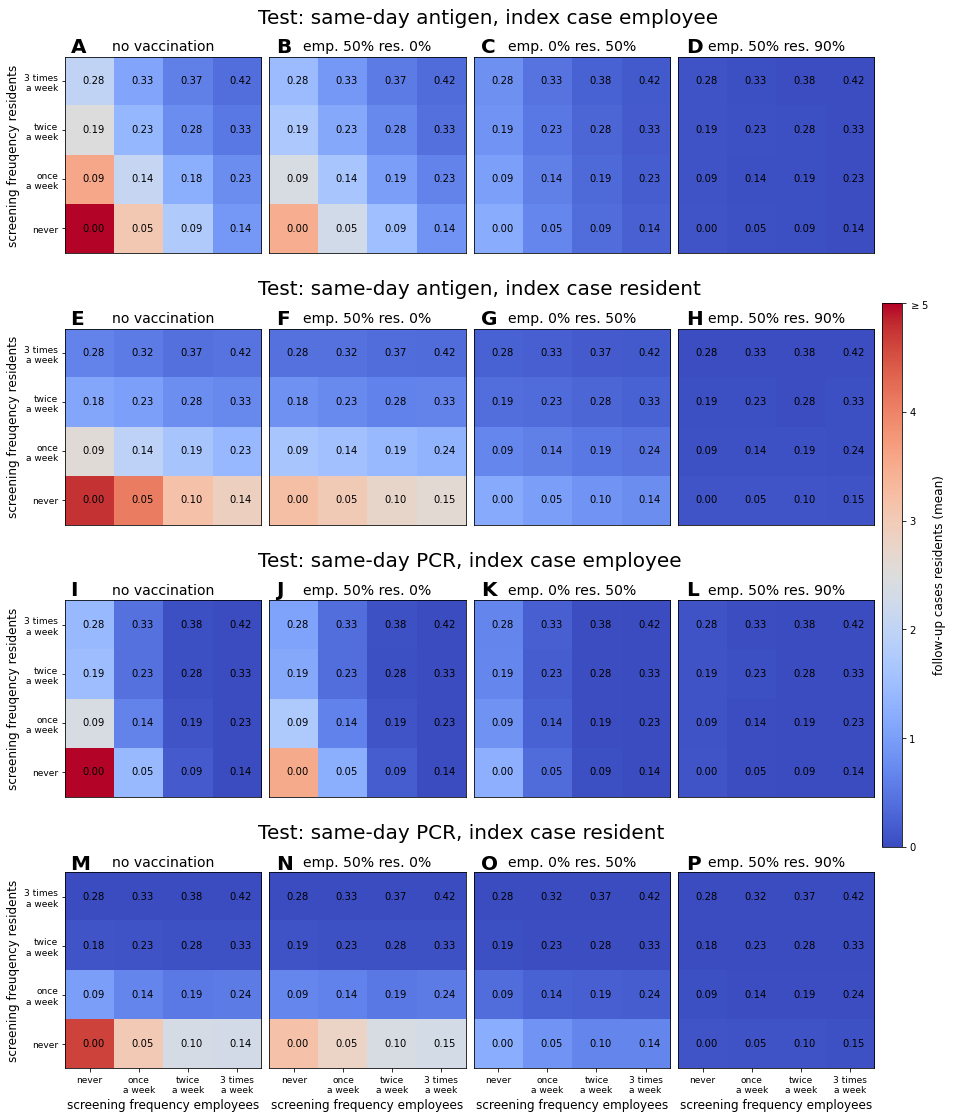

In [92]:
af.plot_testing_strategy_vaccination_scenario_grid(\
    data, 'infected_residents_mean', screening_intervals,
    vaccination_scenarios[0:4], test_name_map, index_case_map,
    vacc_scenario_labels, metric_name_map, xlabel, ylabel, language,
    vmax=5, vstep=1)

### Outbreak sizes

#### Antigen tests & 50% vaccinated residents

In [103]:
mean = data.loc['same_day_antigen', 'employee', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_antigen', 'employee', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3902 +- 1.0765573626848828


In [104]:
mean = data.loc['same_day_antigen', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.8752 +- 1.5404218707574824


#### PCR tests & 0% vaccinated residents, 0% vaccinated employees

In [105]:
mean = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1782 +- 1.2336730319780709


In [106]:
mean = data.loc['same_day_PCR', 'resident', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.3536 +- 3.781828590179241


#### PCR tests & 0% vaccinated residents, 50% vaccinated employees

In [107]:
mean = data.loc['same_day_PCR', 'employee', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1976 +- 1.249026121924858


In [108]:
mean = data.loc['same_day_PCR', 'resident', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.5, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.3834 +- 3.7342192381626087


#### PCR tests & 50% vaccinated residents

In [109]:
mean = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.0, 0.0, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1782 +- 1.2336730319780709


In [110]:
mean = data.loc['same_day_PCR', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.0, 0.5, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6754 +- 1.2623603093848217


#### PCR tests & 90% vaccinated residents, 50% vaccinated employees

In [111]:
mean = data.loc['same_day_PCR', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_PCR', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0038 +- 0.0647023746044601


In [112]:
mean = data.loc['same_day_PCR', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.08499999999999996 +- 0.2996547323032265


#### Antigen tests & 90% vaccinated residents, 50% vaccinated employees

In [113]:
mean = data.loc['same_day_antigen', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean']
std = data.loc['same_day_antigen', 'employee', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0426 +- 0.2181622308095293


In [114]:
mean = data.loc['same_day_antigen', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'resident', 0.5, 0.9, 'twice\na week', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0988 +- 0.3332578163440895


#### No tests & 90% vaccinated residents, 50% vaccinated employees

In [115]:
mean = no_test_data.loc['employee', 0.5, 0.9, 'never', 'never']['infected_residents_mean']
std = no_test_data.loc['employee', 0.5, 0.9, 'never', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.0922 +- 0.3176780506562796


In [116]:
mean = no_test_data.loc['resident', 0.5, 0.9, 'never', 'never']['infected_residents_mean'] - 1
std = no_test_data.loc['resident', 0.5, 0.9, 'never', 'never']['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.09699999999999998 +- 0.3193922389170658
